# Прогнозирование температуры звезды

Требуется для обсерватории создать систему на основе нейросети, которая должна определять температуру на поверхности обнаруженных звёзд.

Обсерватория хочет внедрить технологии машинного обучения для предсказания температуры звёзд, надеясь, что этот метод будет наиболее точным и удобным.

В базе обсерватории есть характеристики уже изученных 240 звёзд.

### Характеристики
- Относительная светимость `L/Lo` — светимость звезды относительно Солнца.
- Относительный радиус `R/Ro` — радиус звезды относительно радиуса Солнца.
- Абсолютная звёздная величина `Mv` — физическая величина, характеризующая блеск звезды.
- Звёздный цвет (`white`, `red`, `blue`, `yellow`, `yellow-orange` и др.) — цвет звезды, который определяют на основе спектрального анализа.
- Тип звезды.

| Тип звезды                        | Номер, соответствующий типу |
|:--------------------------------- |:---------------------------:|
| Коричневый карлик	                | 0                           |
| Красный карлик	                | 1                           |
| Белый карлик	                    | 2                           |
| Звёзды главной последовательности	| 3                           |
| Сверхгигант                       | 4                           |
| Гипергигант                       | 5                           |

- Абсолютная температура `T(K)` — температура на поверхности звезды в Кельвинах.

## Загрузка данных

Загрузим необходимые библиотеки и инструменты.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from skorch import NeuralNetRegressor
from skorch.callbacks import EpochScoring, EarlyStopping
from skorch.dataset import ValidSplit
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

import warnings
warnings.filterwarnings('ignore')

Загрузим таблицу с данными.

In [2]:
try:
    data = pd.read_csv('/datasets/6_class.csv')
except:
    data = pd.read_csv('/neural network/6_class.csv')

In [3]:
data.head()

,Unnamed: 0,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,0,3068,0.002400,0.1700,16.12,0,Red
1,1,3042,0.000500,0.1542,16.60,0,Red
2,2,2600,0.000300,0.1020,18.70,0,Red
3,3,2800,0.000200,0.1600,16.65,0,Red
4,4,1939,0.000138,0.1030,20.06,0,Red


## Предобработка и анализ данных

Изучим таблицу и проверим на явные дубликаты.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              240 non-null    int64  
 1   Temperature (K)         240 non-null    int64  
 2   Luminosity(L/Lo)        240 non-null    float64
 3   Radius(R/Ro)            240 non-null    float64
 4   Absolute magnitude(Mv)  240 non-null    float64
 5   Star type               240 non-null    int64  
 6   Star color              240 non-null    object 
dtypes: float64(3), int64(3), object(1)
memory usage: 13.2+ KB


In [5]:
data.duplicated().sum()

0

Таблица не содержит пропусков и явных дубликатов.

Приведём название столбцов к стандарту PEP8.

In [6]:
data = data.rename(columns={'Unnamed: 0': 'unnamed',
    'Temperature (K)': 'temperature',
    'Luminosity(L/Lo)': 'luminosity',
    'Radius(R/Ro)': 'radius',
    'Absolute magnitude(Mv)': 'absolute_magnitude',
    'Star type': 'star_type',
    'Star color': 'star_color'                        
})

In [7]:
data.columns

Index(['unnamed', 'temperature', 'luminosity', 'radius', 'absolute_magnitude',
       'star_type', 'star_color'],
      dtype='object')

In [8]:
data = data.drop('unnamed', axis=1)

Поменяем тип столбца `star_type`, так как он содержит категориальные значения.

In [9]:
data['star_type'] = data['star_type'].astype('category')

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   temperature         240 non-null    int64   
 1   luminosity          240 non-null    float64 
 2   radius              240 non-null    float64 
 3   absolute_magnitude  240 non-null    float64 
 4   star_type           240 non-null    category
 5   star_color          240 non-null    object  
dtypes: category(1), float64(3), int64(1), object(1)
memory usage: 9.9+ KB


Изучим столбец `star_type`, посмотрим количество строк для каждой категории.

In [11]:
data['star_type'].value_counts()

0    40
1    40
2    40
3    40
4    40
5    40
Name: star_type, dtype: int64

Изучим столбец `star_type`, проверим на неявные дубликаты.

In [12]:
data['star_color'].unique()

array(['Red', 'Blue White', 'White', 'Yellowish White', 'Blue white',
       'Pale yellow orange', 'Blue', 'Blue-white', 'Whitish',
       'yellow-white', 'Orange', 'White-Yellow', 'white', 'Blue ',
       'yellowish', 'Yellowish', 'Orange-Red', 'Blue white ',
       'Blue-White'], dtype=object)

Столбец содержит много неявных дубликатов, приведём название категорий к единому виду. Так как спектральных классов звёзд всего семь - объединим близкие цвета к единому названию.

In [13]:
data['star_color'] = data['star_color'].replace({'Red': 'red',
    'Blue White': 'blue_white',
    'Blue white': 'blue_white',
    'Blue-white': 'blue_white',
    'Blue white ': 'blue_white',
    'Blue-White': 'blue_white',
    'White': 'white',
    'Whitish': 'white',
    'Yellowish White': 'yellow_white',
    'yellow-white': 'yellow_white',
    'White-Yellow': 'yellow_white',
    'Orange': 'orange',
    'Orange-Red': 'orange',
    'Blue': 'blue',
    'Blue ': 'blue',
    'Yellowish': 'yellow',
    'yellowish': 'yellow',
    'Pale yellow orange': 'yellow'
})

In [14]:
data['star_color'].value_counts()

red             112
blue             56
blue_white       41
white            12
yellow_white     12
yellow            4
orange            3
Name: star_color, dtype: int64

Построим гистограммы и боксплот для количественных признаков.

In [15]:
plt.style.use('fivethirtyeight')

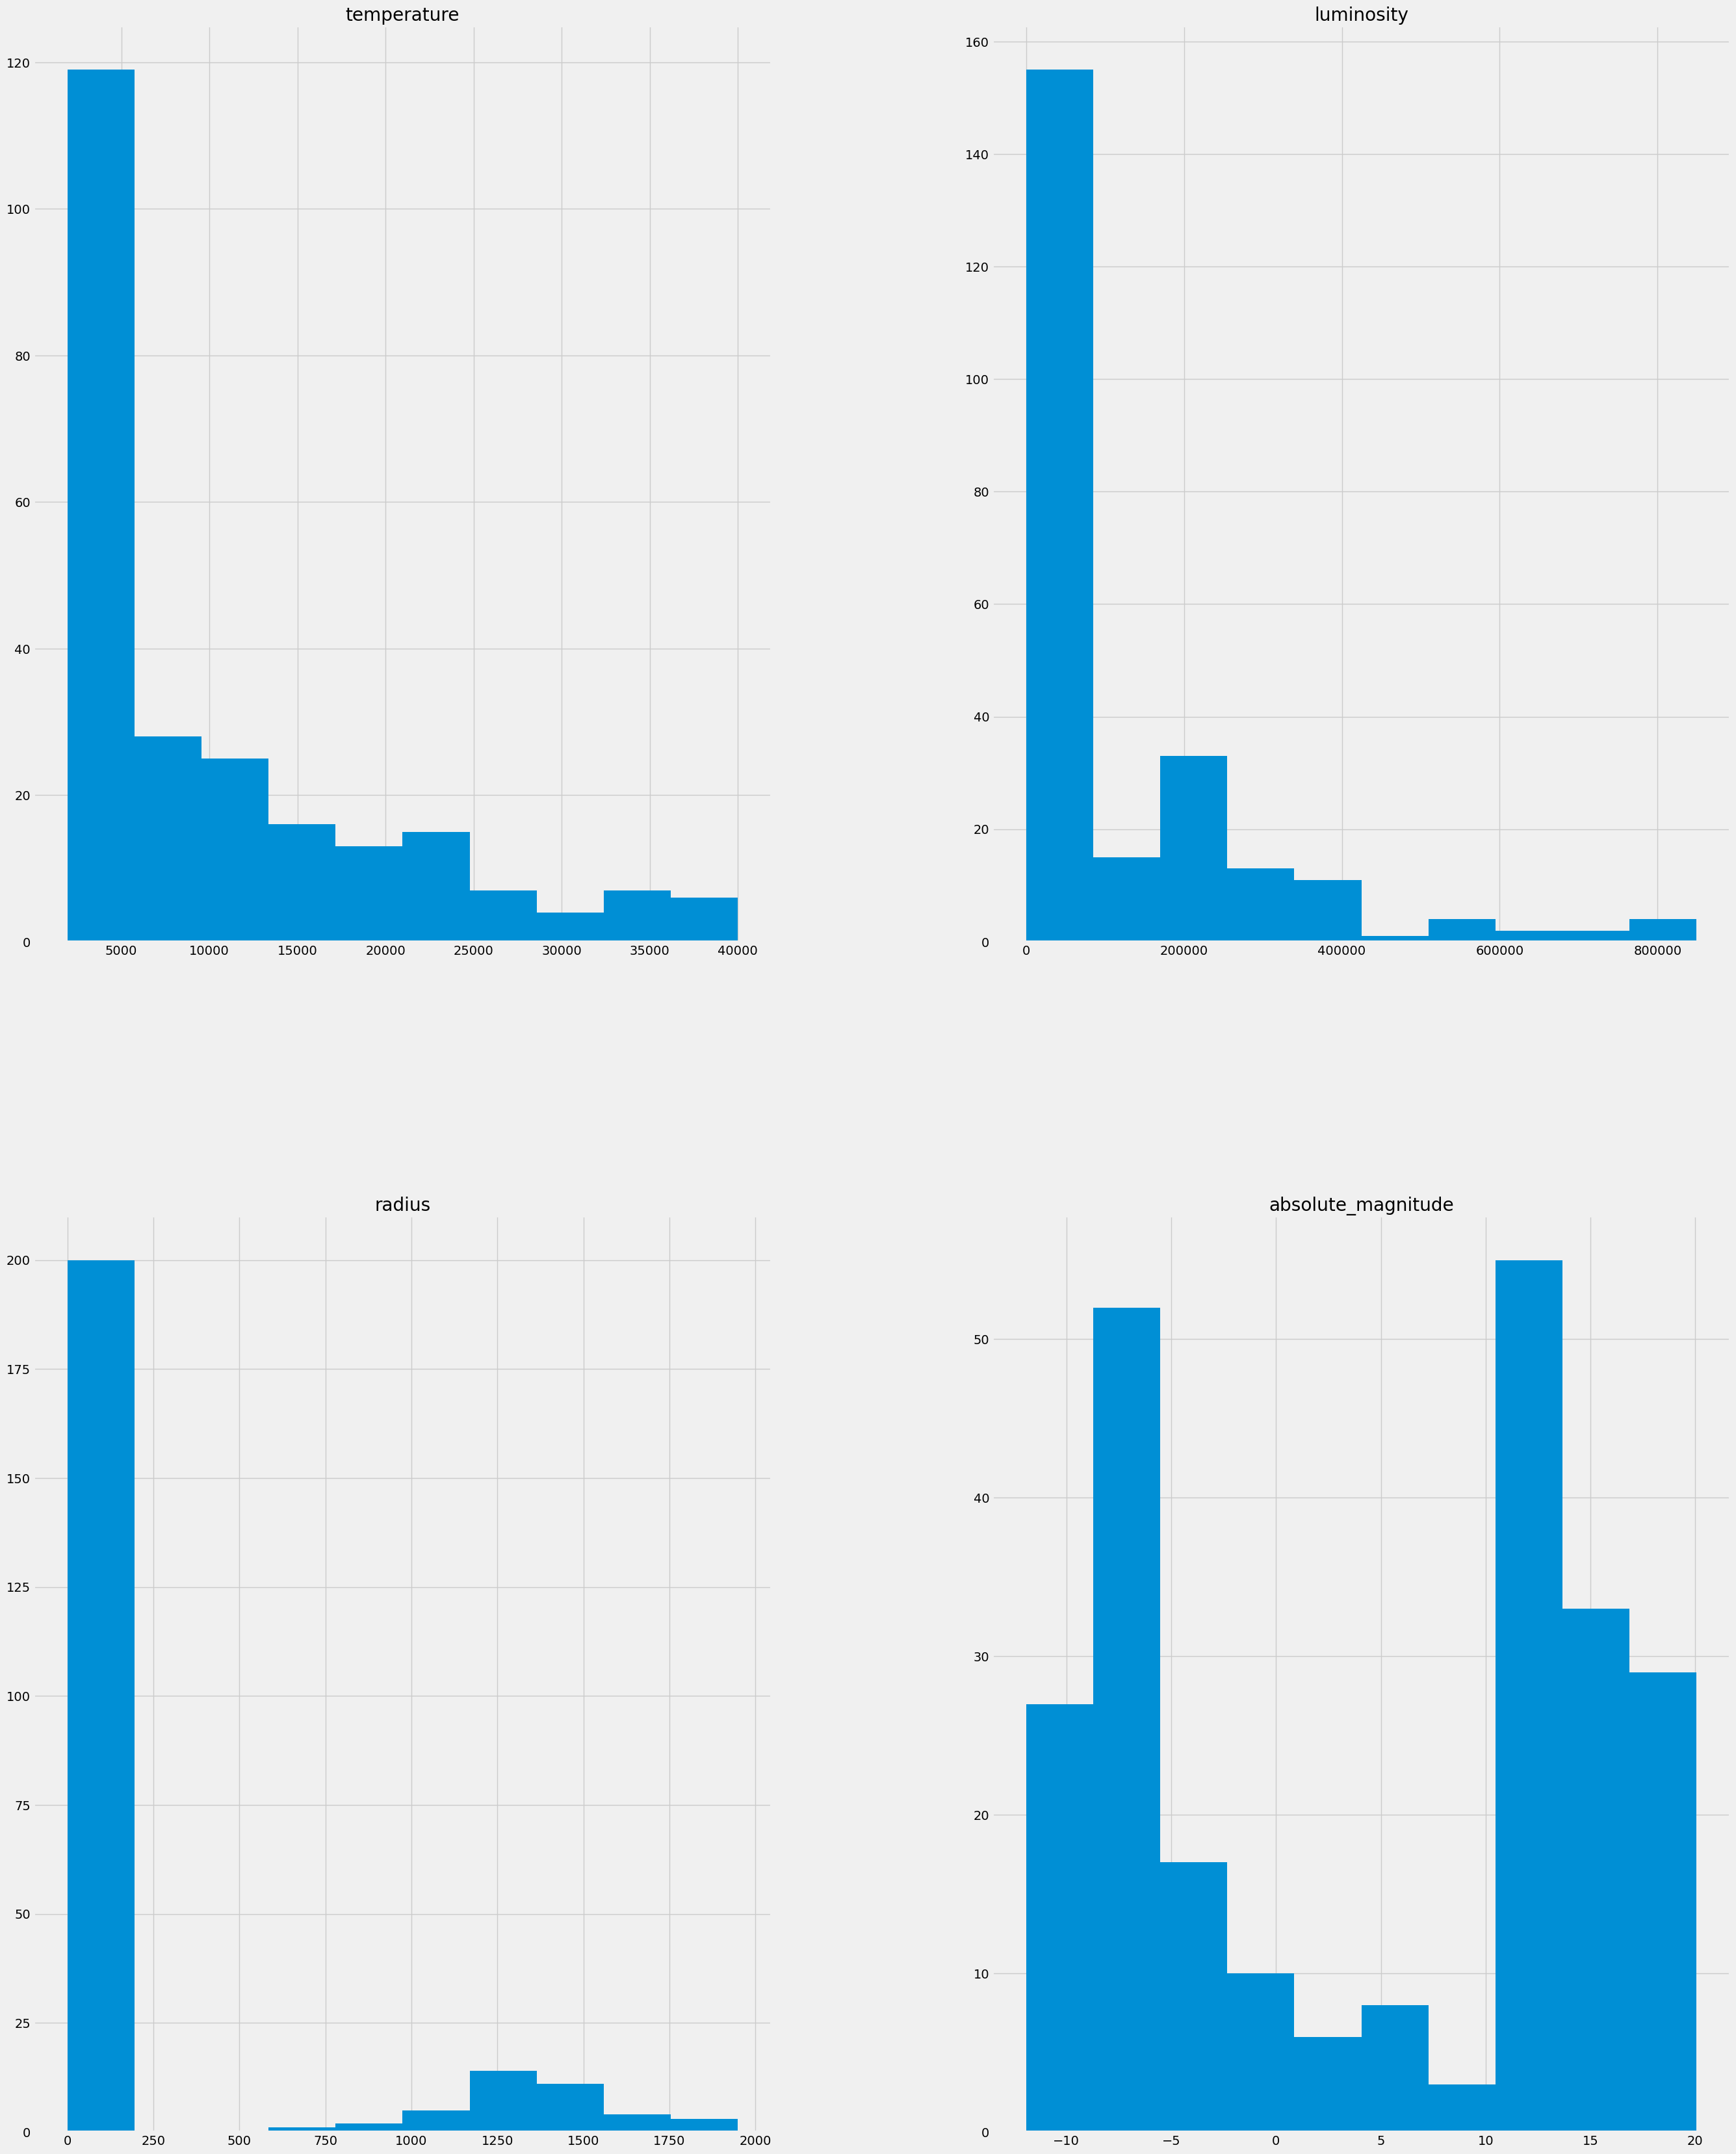

In [16]:
data.hist(figsize=(30, 40));

In [17]:
data.describe()

,temperature,luminosity,radius,absolute_magnitude
count,240.000000,240.000000,240.000000,240.000000
mean,10497.462500,107188.361635,237.157781,4.382396
std,9552.425037,179432.244940,517.155763,10.532512
min,1939.000000,0.000080,0.008400,-11.920000
25%,3344.250000,0.000865,0.102750,-6.232500
50%,5776.000000,0.070500,0.762500,8.313000
75%,15055.500000,198050.000000,42.750000,13.697500
max,40000.000000,849420.000000,1948.500000,20.060000


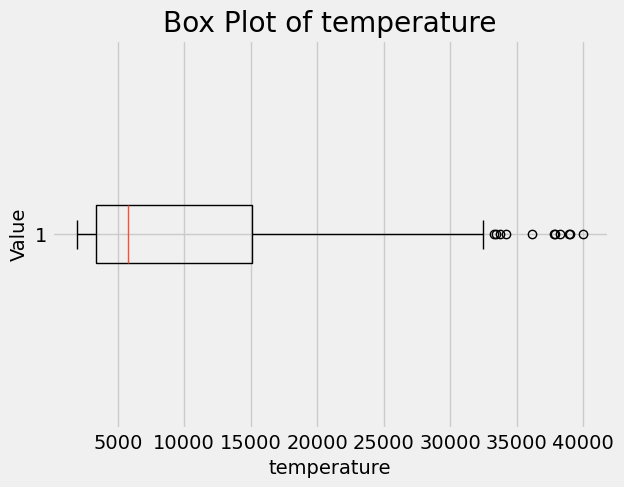

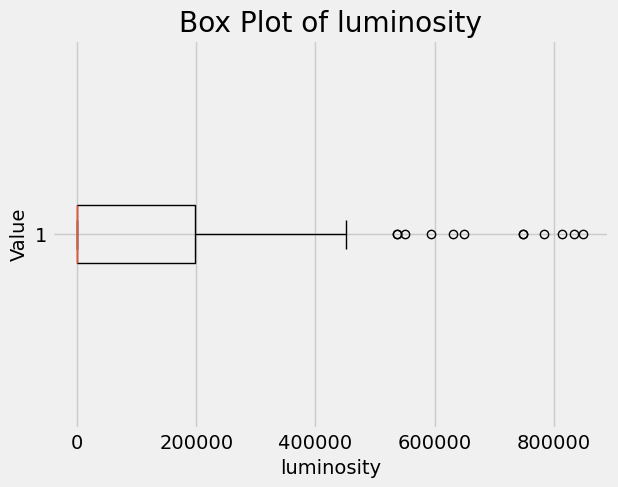

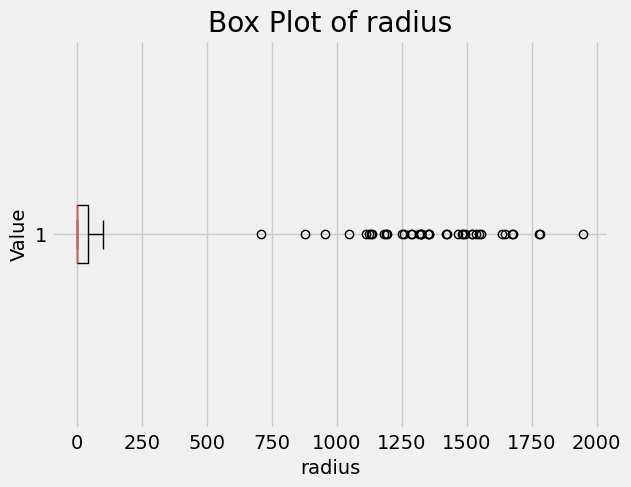

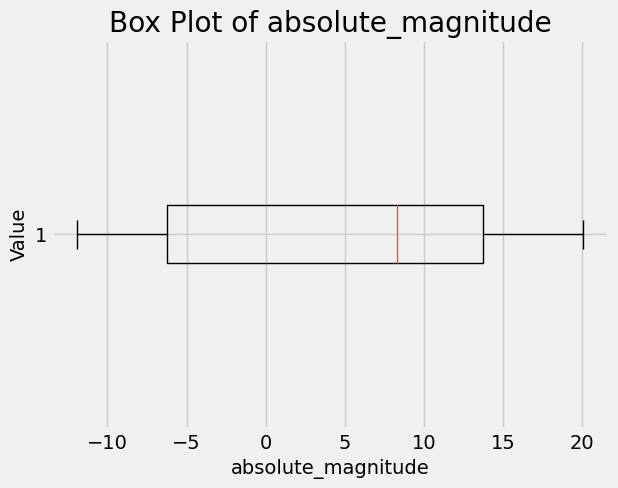

In [18]:
stats = data.describe()

for column in stats.columns:
    plt.boxplot(data[column], vert=False)
    plt.xlabel(column)
    plt.ylabel('Value')
    plt.title(f'Box Plot of {column}')
    plt.show()

Из графиков видно следующее:
- подавляющее количество звёзд имеет теммпературу около 5000 К, однако температура звёзд может достигать значений до 40000 К. Выбросов нет;
- относительная светимость имеет похожее соотношение - основная часть звёзд имеет очень низкую светимость - чуть выше нулевых значений, однако светимость некоторых звёзд может достигать 850000 L/Lo относительно Солнца. Выбросов нет;
- радиус абсолютного большинства звёзд относительно Солнца небольшой -до 1 R/Ro, звёзд размером до 1000 R/Ro совсем мало, много больше звёзд размером около 1250 R/Ro, максимальный размер звезды - 1950 R/Ro. Выбросов нет;
- абсолютная звёздная величина находится в пределах от -12 до 20 Mv. В основном значения находятся в начале и в конце диапазона. Выбросов нет. 

**Изучим признаки подробнее. Посмотрим соотношение каждого признака по типам звёзд. Сравним среднее и медианное значение.**

Абсолютная температура `T(K)` — температура на поверхности звезды в Кельвинах.

In [19]:
data_temperature = data.pivot_table(index='star_type', values='temperature', aggfunc=['median', 'mean']).reset_index()
data_temperature.columns = ['Тип звезды', 'Медианная температура', 'Средняя температура']
data_temperature

,Тип звезды,Медианная температура,Средняя температура
0,0,2935.0,2997.950
1,1,3314.0,3283.825
2,2,13380.0,13931.450
3,3,12560.5,16018.000
4,4,12821.0,15347.850
5,5,3766.0,11405.700


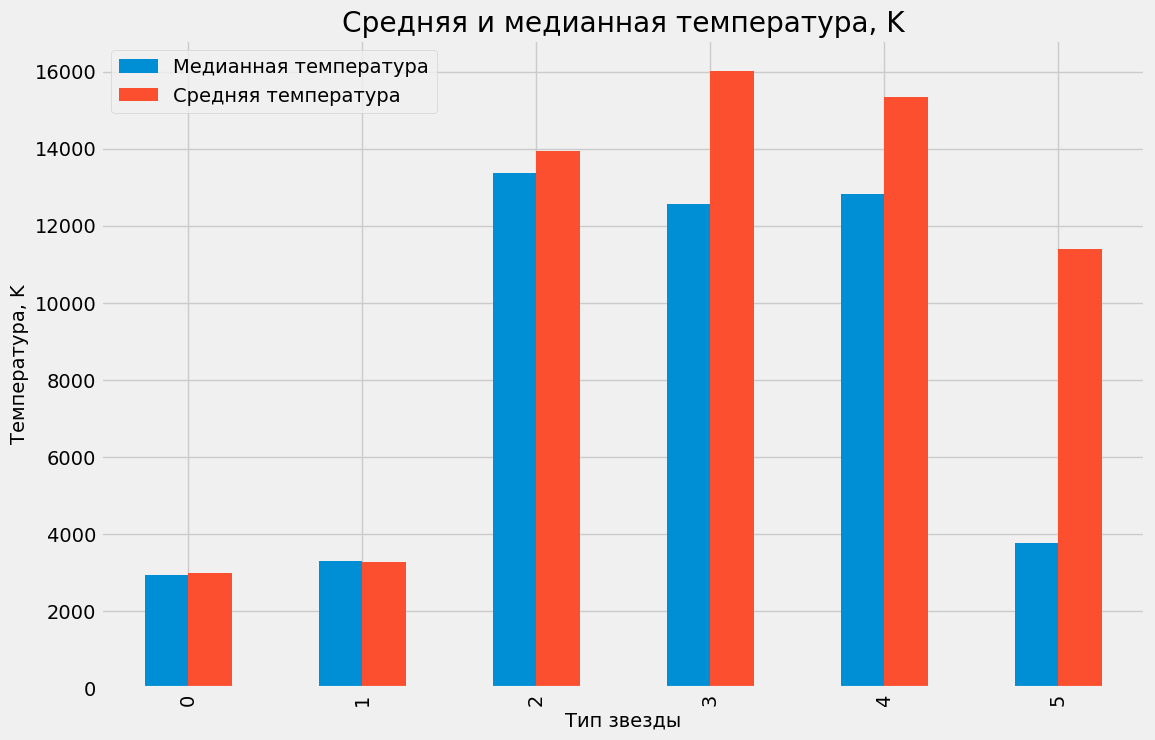

In [20]:
data_temperature.plot(x='Тип звезды', y=['Медианная температура', 'Средняя температура'], \
                     kind='bar', grid=True, figsize=(12, 8), title='Средняя и медианная температура, K')
plt.xlabel('Тип звезды')
plt.ylabel('Температура, K');

**Относительная светимость `L/Lo` — светимость звезды относительно Солнца.**

In [21]:
data_luminosity = data.pivot_table(index='star_type', values='luminosity', aggfunc=['median', 'mean']).reset_index()
data_luminosity.columns = ['Тип звезды', 'Медианная относительная светимость', 'Средняя относительная светимость']
data_luminosity

,Тип звезды,Медианная относительная светимость,Средняя относительная светимость
0,0,0.00052,0.000693
1,1,0.00315,0.005406
2,2,0.00076,0.002434
3,3,738.50000,32067.386275
4,4,242145.00000,301816.250000
5,5,266500.00000,309246.525000


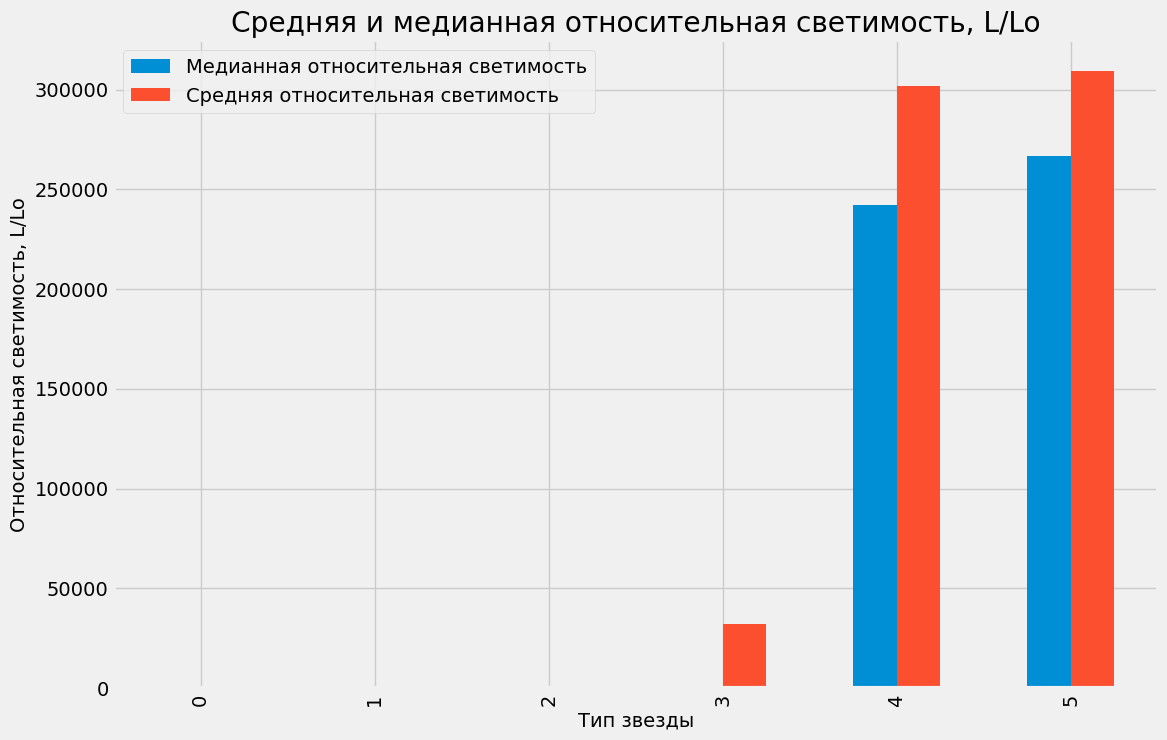

In [22]:
data_luminosity.plot(x='Тип звезды', y=['Медианная относительная светимость', 'Средняя относительная светимость'], \
                     kind='bar', grid=True, figsize=(12, 8), title='Средняя и медианная относительная светимость, L/Lo')
plt.xlabel('Тип звезды')
plt.ylabel('Относительная светимость, L/Lo');

**Относительный радиус `R/Ro` — радиус звезды относительно радиуса Солнца.**

In [23]:
data_radius = data.pivot_table(index='star_type', values='radius', aggfunc=['median', 'mean']).reset_index()
data_radius.columns = ['Тип звезды', 'Медианный относительный радиус звезды', 'Средний относительный радиус звезды']
data_radius

,Тип звезды,Медианный относительный радиус звезды,Средний относительный радиус звезды
0,0,0.1060,0.110015
1,1,0.3380,0.348145
2,2,0.0102,0.010728
3,3,5.7125,4.430300
4,4,43.5000,51.150000
5,5,1352.5000,1366.897500


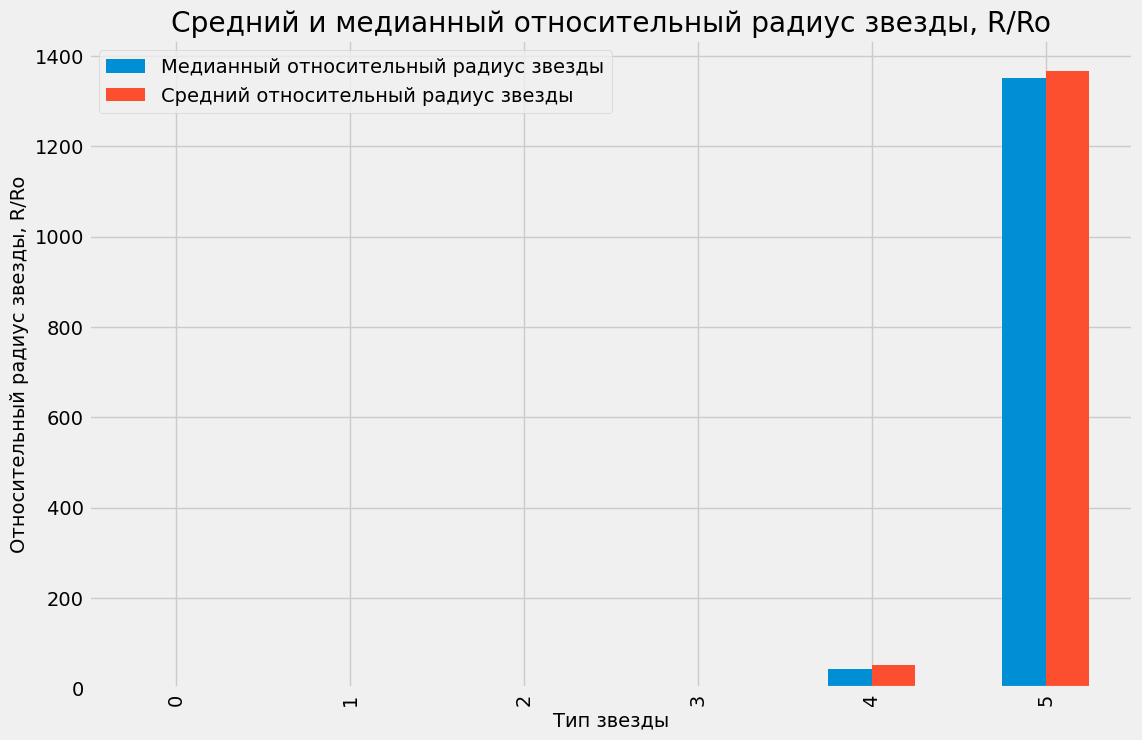

In [24]:
data_radius.plot(x='Тип звезды', y=['Медианный относительный радиус звезды', 'Средний относительный радиус звезды'], \
                     kind='bar', grid=True, figsize=(12, 8), title='Средний и медианный относительный радиус звезды, R/Ro')
plt.xlabel('Тип звезды')
plt.ylabel('Относительный радиус звезды, R/Ro');

**Абсолютная звёздная величина `Mv` — физическая величина, характеризующая блеск звезды.**

In [25]:
data_absolute_magnitude = data.pivot_table(index='star_type', values='absolute_magnitude', aggfunc=['median', 'mean']).reset_index()
data_absolute_magnitude.columns = ['Тип звезды', 'Медианная абсолютная звёздная величина', 'Средняя абсолютная звёздная величина']
data_absolute_magnitude

,Тип звезды,Медианная абсолютная звёздная величина,Средняя абсолютная звёздная величина
0,0,17.145,17.563500
1,1,12.605,12.539975
2,2,12.340,12.582500
3,3,-1.180,-0.367425
4,4,-6.235,-6.369925
5,5,-9.915,-9.654250


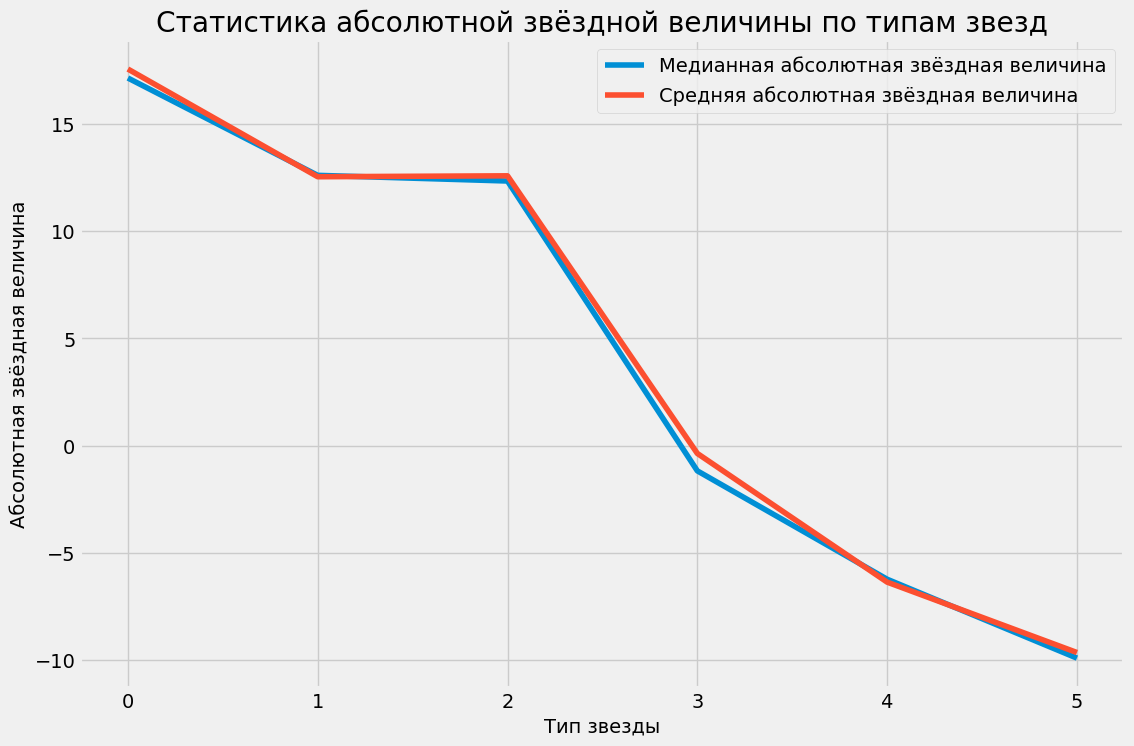

In [26]:
data_absolute_magnitude.plot(x='Тип звезды', y=['Медианная абсолютная звёздная величина',
                                                'Средняя абсолютная звёздная величина'], 
                                               kind='line', figsize=(12, 8))
plt.xlabel('Тип звезды')
plt.ylabel('Абсолютная звёздная величина')
plt.title('Статистика абсолютной звёздной величины по типам звезд')
plt.legend()
plt.show()

Посмотрим какие цвета имеют звёзды по типам.

In [27]:
cross_table = pd.crosstab(data['star_type'], data['star_color'])

cross_table

star_color,blue,blue_white,orange,red,white,yellow,yellow_white
star_type,,,,,,,
0,0,0,0,40,0,0,0
1,0,0,0,40,0,0,0
2,13,14,0,0,8,1,4
3,5,21,1,0,2,3,8
4,31,0,0,9,0,0,0
5,7,6,2,23,2,0,0


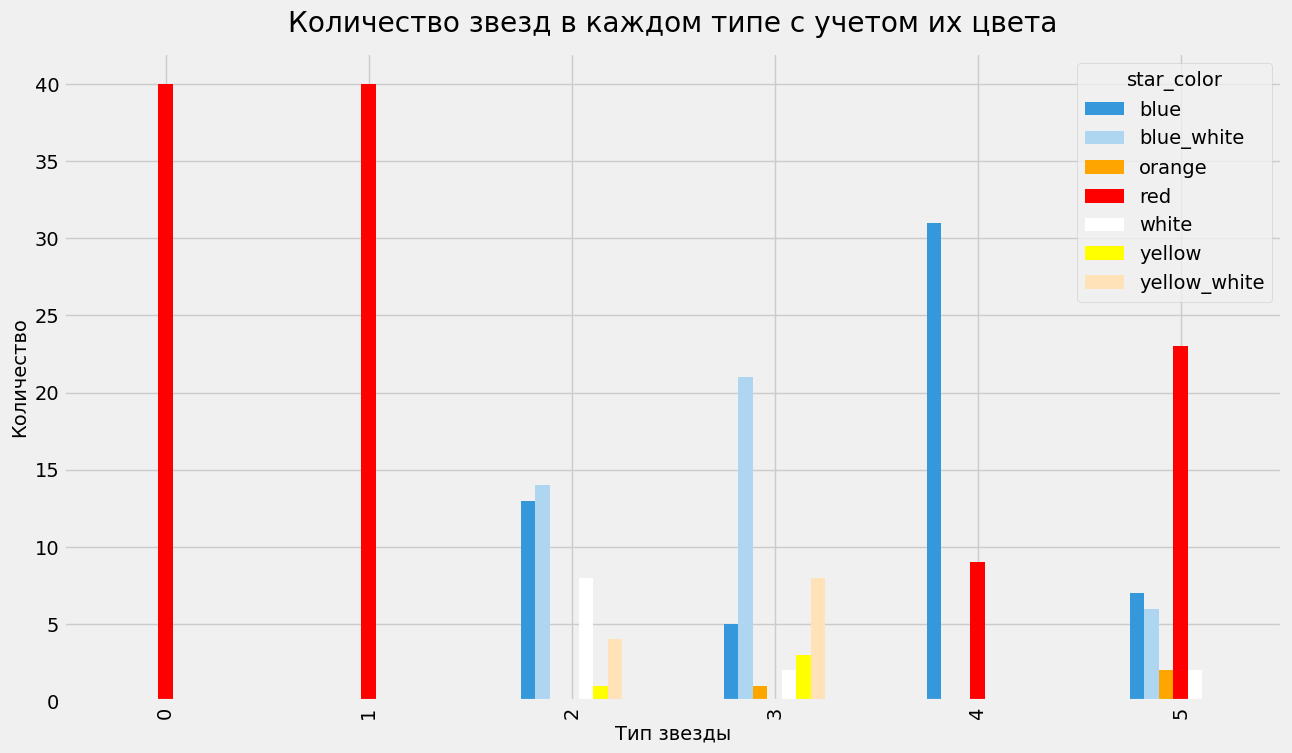

In [28]:
color = {'red': 'red',
          'blue_white': '#AED6F1',
          'white': 'white',
          'blue': '#3498DB',
          'orange': 'orange',
          'yellow_white': '#FFE2B7',
          'yellow': '#ffff00'}
#cross_table.plot(kind='bar', grid=True, figsize=(12, 8), color=color, title='Количество звёзд каждого цвета по группам')
#plt.xlabel('Тип звезды')
#plt.ylabel('Количество звёзд');
ax = pd.crosstab(data['star_type'], data['star_color']).plot.bar(figsize=(14, 8), color=color)
ax.set_title('Количество звезд в каждом типе с учетом их цвета', y=1.02)
ax.set_ylabel('Количество')
ax.set_xlabel('Тип звезды');

Звёзды карлики 0-го и 1-го типа имеют исключительно красный цвет, красный цвет имеет и большое количество звёзд типов 4 и 5, 4-му типу однако больше свойственнен синий цвет звёзд. Звёзды остальных цветов как и звёзды синего цвета соответствуют 2-му и 3-му типу, но встречаются и в пятом типе звёзд. Это напервый взгляд выглядит неправдоподобно, но на самом деле соответствует диаграмме Герцшпрунга-Рассела ([источник](https://kosmosgid.ru/zvyozdy/osnovnye-harakteristiki-zvyozd))
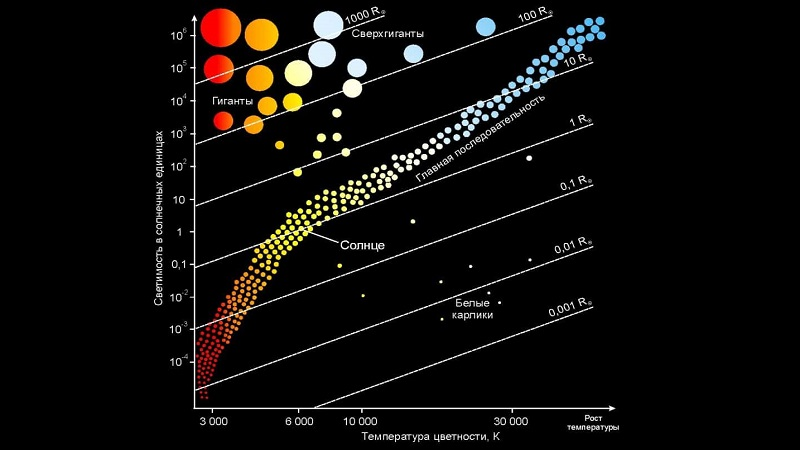

Посмотрим как коррелируют признаки с таргетом.

In [29]:
data.corr()[['temperature']].sort_values('temperature', ascending=False)

,temperature
temperature,1.000000
luminosity,0.393404
radius,0.064216
absolute_magnitude,-0.420261


**Вывод.**

На графиках видно:
- наибольшая температура на поверхности у звёзд типа 2, 3 и 4. У крупных и маленьких звёзд температура практически одинаково невысокая. Кроме того у звёзд-гигантов медианная температура значительно ниже средней, что может говорить о том, что в этой категории преобладают звёзды с относительно низкой температурой;
- светимость звёзд типов от 0 по 3 очень низкая, и разительно отличается от светимости крупных звёзд, который напротив очень яркие;
- радиус относительно Солнца по типу распределён непоследовательно, самые маленький средний радиус у звёзд в типа 2, он в десять раз меньше радиуса звёзд типа 0 и в 35 раз меньше радиуса звёзд типа 1, однако у типа 3 звёзды имеют уже радиус больше в 400-500 раз больше радиуса звёзд типа 2, в 4-м в 10 раз больше, чем в 3-м типе, а в пятом типе - звёзды-гипергиганты, их радиус больше чем в 25 раз превосходит радиус звёзд 4-го типа и в 135000 раз превосходит радиус звёзд 2-го типа;
- абсолютная звёздная величина плавно снижается для звёзд от 0-го до 5-го типа, исключение опять тип 2, звёзды в нем обладают абсолютной звёздной величиной как звёзды типа 1.

Видно, что на температуру звезды сильно влияют Относительная светимость и Абсолютная звёздная величина, в то время как радиус звезды на температуру почти не влияет.

## Подготовка данных

Разобьём данные на тренировочную и тестовую выборки.

In [30]:
features_train, features_test, target_train, target_test = train_test_split(data.drop('temperature', axis = 1),
                                                    data['temperature'],
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=1)
print(features_train.shape, features_test.shape, target_train.shape, target_test.shape)

(192, 5) (48, 5) (192,) (48,)


Используем конструктор ColumnTransformer, масштабируем чмсловые признаки с помощью StandardScaler и преобразуем категориальные признаки с помощью OneHotEncoder.

In [31]:
numerics = ['luminosity', 'radius', 'absolute_magnitude']
categorical = ['star_color', 'star_type']

col_transformer = ColumnTransformer(
                        transformers=[
                            ('scaler', StandardScaler(), numerics),
                            ('ohe', OneHotEncoder(sparse=False), categorical)],
                                remainder="passthrough"
                                  )

col_transformer.fit(data.drop('temperature', axis=1))
features_train = col_transformer.transform(features_train)
features_test = col_transformer.transform(features_test)

In [32]:
print(features_train.shape)
print(target_train.shape)
print(features_test.shape)
print(target_test.shape)

(192, 16)
(192,)
(48, 16)
(48,)


## Построение базовой нейронной сети

Переведём выборки в тензоры.

In [33]:
features_train = torch.FloatTensor(np.array(features_train))
features_test = torch.FloatTensor(np.array(features_test))
target_train = torch.FloatTensor(np.array(target_train))
target_test = torch.FloatTensor(np.array(target_test))

Построим простую нейронную сеть с двумя скрытыми слоями, функции активации и количество нейронов в скрытых слоях подберём вручную.

In [34]:
class Net(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2) 
        self.act2 = nn.ReLU()
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        return x

In [35]:
n_in_neurons = features_train.shape[1]
n_hidden_neurons_1 = 15
n_hidden_neurons_2 = 10
n_out_neurons = 1

In [36]:
net = Net(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
loss = nn.MSELoss()

In [37]:
dataset_train = torch.utils.data.TensorDataset(features_train, target_train)
dataset_test = torch.utils.data.TensorDataset(features_test, target_test)

train_dataloader = DataLoader(dataset_train, batch_size=40, shuffle=True,
                              num_workers=0)
test_dataloader = DataLoader(dataset_test, batch_size=40, num_workers=0)  

Для ранней остановки обучения, когда потеря больше не улучшается после определённой эпохи, создадим класс, который назовём EarlyStopping, и ипользуем его при обучении нейросети.

In [38]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta

    def __call__(self, score):
        if self.best_score is None:
            self.best_score = score
        elif self.best_score - score > self.delta:
            self.best_score = score
            # reset counter if validation loss improves
            self.counter = 0
        elif self.best_score - score < self.delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

Обучаем нейросеть.

In [39]:
early_stopping = EarlyStopping(patience=5, delta=20)

num_epochs = 50000
for epoch in range(num_epochs):
    net.train()
    for batch in train_dataloader:
        data_train, temperature_train = batch # выгружаем данные 
        optimizer.zero_grad()

        preds = net.forward(data_train).flatten()

        loss_value = torch.sqrt(loss(preds, temperature_train))
        loss_value.backward()
        optimizer.step()
    
    if epoch % 100 == 0:
        predicted_temp = [] 
        with torch.no_grad():
            net.eval()
            for batch in test_dataloader:
                data_test, temperature_test = batch # выгружаем данные

                test_preds = net.forward(data_test).flatten()
                predicted_temp.append(test_preds)
                RMSE_loss = torch.sqrt(loss(test_preds, temperature_test))

        predicted_temp = torch.cat(predicted_temp).detach().numpy()
        RMSE = mean_squared_error(target_test, predicted_temp, squared=False)
        early_stopping(RMSE)
        if early_stopping.counter == 0:
            best_rmse = RMSE
            best_predicted_temp = predicted_temp
        print(f"epoch:{epoch}, RMSE test: {RMSE}")

        if early_stopping.early_stop:
            print()
            print('Early Stopping!')
            print()
            print(f'Best RMSE test {best_rmse}')
            break

epoch:0, RMSE test: 15201.3408203125
epoch:100, RMSE test: 14980.1279296875
epoch:200, RMSE test: 13537.470703125
epoch:300, RMSE test: 10826.3095703125
epoch:400, RMSE test: 8591.78515625
epoch:500, RMSE test: 7887.62451171875
epoch:600, RMSE test: 7584.82568359375
epoch:700, RMSE test: 7289.35888671875
epoch:800, RMSE test: 6979.61572265625
epoch:900, RMSE test: 6680.76025390625
epoch:1000, RMSE test: 6413.3251953125
epoch:1100, RMSE test: 6170.1494140625
epoch:1200, RMSE test: 5971.80419921875
epoch:1300, RMSE test: 5799.7822265625
epoch:1400, RMSE test: 5662.958984375
epoch:1500, RMSE test: 5558.3203125
epoch:1600, RMSE test: 5476.94677734375
epoch:1700, RMSE test: 5421.65283203125
epoch:1800, RMSE test: 5375.2275390625
epoch:1900, RMSE test: 5333.17578125
epoch:2000, RMSE test: 5300.60986328125
epoch:2100, RMSE test: 5269.35791015625
epoch:2200, RMSE test: 5234.64697265625
epoch:2300, RMSE test: 5202.041015625
epoch:2400, RMSE test: 5170.4560546875
epoch:2500, RMSE test: 5137.0883

Напишем функцию для построения графика "Факт-прогноз".

In [40]:
def fact_forecast(test_preds, target_test):
    
    y1 = torch.FloatTensor(test_preds)
    y1 = y1.detach().numpy().reshape([-1])
    y2 = target_test.detach().numpy().reshape([-1])
    x = np.arange(len(y1))

    fig,ax = plt.subplots()
    fig.set_figwidth(18)
    fig.set_figheight(8)
    ax.set_xticks(x)
    fact = ax.bar(x, y2, width = 0.6, label = 'Факт')
    forecast = ax.bar(x, y1, width = 0.3, label = 'Прогноз')
    ax.legend()
    ax.set_title('График "Факт-прогноз"', fontsize=20)
    ax.set_xlabel('Номер звезды')
    ax.set_ylabel('Температура звезды')
    plt.show()

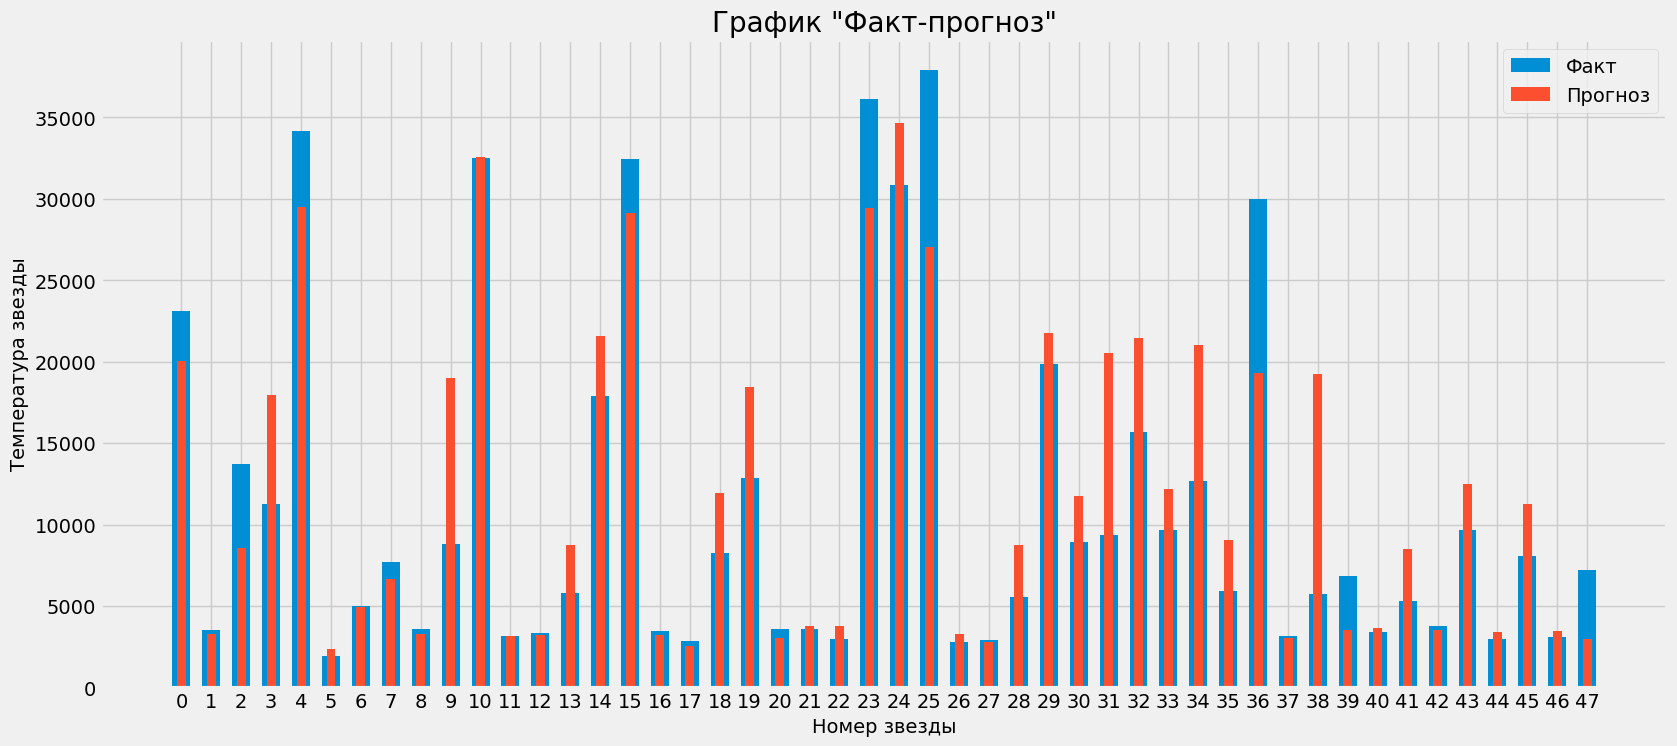

In [41]:
fact_forecast(predicted_temp, target_test)

Базовая нейронная сеть показала не очень хороший результат - RMSE 4771, и по графику видно, что наша модель часто ошибается, показывая температуру то больше, то меньше истинной, иногда даже больше 10000 К. Возможно это связвно с тем, что выборка у нас довольно маленькая, на большем количестве данных нейросеть смогла бы показать лучшие результаты. 

## Улучшение нейронной сети

Для улучшения модели используем три версии оптимизатора Adam, для каждого подберём гиперпараметр `lr` и обучим нейросеть с каждым вариантом оптимайзера, чтобы найти наилучший и использовать его далее.

In [42]:
n_in_neurons = features_train.shape[1]
n_hidden_neurons_1 = 15
n_hidden_neurons_2 = 10
n_out_neurons = 1

net = Net(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons)

optimizers = [
(torch.optim.Adam, 1e-3),
(torch.optim.NAdam, 1e-2),
(torch.optim.Adamax, 1e-2),
(torch.optim.Adamax, 1e-3),
(torch.optim.Adam, 1e-2),
(torch.optim.NAdam, 1e-3)
]

In [43]:
rmse_optimizers = []

for optimizer_class, lr in optimizers:
    net = Net(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons)
    optimizer = optimizer_class(net.parameters(), lr=lr)

    early_stopping = EarlyStopping(patience=5, delta=20)

    num_epochs = 50000
    for epoch in range(num_epochs):
        net.train()
        for batch in train_dataloader:
            data_train, temperature_train = batch
            optimizer.zero_grad()

            preds = net.forward(data_train).flatten()
            loss_value = torch.sqrt(loss(preds, temperature_train))
            loss_value.backward()
            optimizer.step()

        if epoch % 100 == 0:
            predicted_temp = []
            with torch.no_grad():
                net.eval()
                for batch in test_dataloader:
                    data_test, temperature_test = batch
                    test_preds = net.forward(data_test).flatten()
                    predicted_temp.append(test_preds)

                predicted_temp = torch.cat(predicted_temp).detach().numpy()
                RMSE = mean_squared_error(target_test, predicted_temp, squared=False)
                early_stopping(RMSE)

                if early_stopping.counter == 0:
                    best_rmse = RMSE
                    best_predicted_temp = predicted_temp
                print(f"epoch:{epoch}, RMSE test: {RMSE}")

                if early_stopping.early_stop:
                    print()
                    print('Early Stopping!')
                    print()
                    print(optimizer)
                    print()
                    print(f'Best RMSE test {best_rmse}')
                    print('-' * 30)
                    print()
                    rmse_optimizers.append(round(best_rmse, 2))
                    break

epoch:0, RMSE test: 15201.0380859375
epoch:100, RMSE test: 15005.91796875
epoch:200, RMSE test: 13718.822265625
epoch:300, RMSE test: 11218.12109375
epoch:400, RMSE test: 8881.7509765625
epoch:500, RMSE test: 7970.458984375
epoch:600, RMSE test: 7653.29541015625
epoch:700, RMSE test: 7373.662109375
epoch:800, RMSE test: 7086.7607421875
epoch:900, RMSE test: 6800.15673828125
epoch:1000, RMSE test: 6531.34912109375
epoch:1100, RMSE test: 6283.345703125
epoch:1200, RMSE test: 6070.1181640625
epoch:1300, RMSE test: 5888.28271484375
epoch:1400, RMSE test: 5737.4833984375
epoch:1500, RMSE test: 5618.9541015625
epoch:1600, RMSE test: 5529.46826171875
epoch:1700, RMSE test: 5459.396484375
epoch:1800, RMSE test: 5408.302734375
epoch:1900, RMSE test: 5366.0703125
epoch:2000, RMSE test: 5328.5263671875
epoch:2100, RMSE test: 5294.474609375
epoch:2200, RMSE test: 5268.1328125
epoch:2300, RMSE test: 5243.23779296875
epoch:2400, RMSE test: 5213.00439453125
epoch:2500, RMSE test: 5185.68359375
epoch:

In [44]:
optimizers_rmse = pd.DataFrame(data = rmse_optimizers, index = ['Adam, lr: 0.001',
                                                                'NAdam, lr: 0.01',
                                                                'Adamax, lr: 0.01',
                                                                'Adamax, lr: 0.001',
                                                                'Adam, lr: 0.01',
                                                                'NAdam, lr: 0.001'], columns = ['RMSE'])
display(optimizers_rmse.sort_values(by='RMSE'))

,RMSE
"Adam, lr: 0.01",4090.479980
"Adamax, lr: 0.01",4117.299805
"Adam, lr: 0.001",4160.799805
"NAdam, lr: 0.01",4167.359863
"NAdam, lr: 0.001",4778.089844
"Adamax, lr: 0.001",4953.799805


Наилучшие показатели у оптимизатора Adam c lr 0.01. 

Добавим в класс Net методы регуляризации `dropout` и `BatchNorm`, попробуем применить их в различных сочетаниях и оставим наилучшую комбинацию.

In [45]:
class Net(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons, dropout_rate):
            super(Net, self).__init__()

            self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
            self.bn1 = nn.BatchNorm1d(n_hidden_neurons_1)
            self.act1 = nn.ReLU()
            self.dp2 = nn.Dropout(p=dropout_rate)
            self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
            self.act2 = nn.ReLU()
            self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.dp2(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)

        return x

Подберём лучшие параметры «dropout» и «размер батча».

In [46]:
dropout_rates = [0.2, 0.5]
batch_sizes = [16, 32]

best_rmse = float('inf')
best_hyperparameters = None
best_rmse_so_far = float('inf')
best_hyperparameters_so_far = None


for dropout_rate in dropout_rates:
    for batch_size in batch_sizes:
        
        net = Net(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons, dropout_rate)
        optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)


        train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
        test_dataloader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)


        early_stopping = EarlyStopping(patience=5, delta=20)


        num_epochs = 50000


        for epoch in range(num_epochs):
            net.train()


            for batch in train_dataloader:
                data_train, temperature_train = batch
                optimizer.zero_grad()


                preds = net.forward(data_train).flatten()


                loss_value = torch.sqrt(loss(preds, temperature_train))
                loss_value.backward()
                optimizer.step()


            if epoch % 100 == 0:
                predicted_temp = []


                with torch.no_grad():
                    net.eval()


                    for batch in test_dataloader:
                        data_test, temperature_test = batch
                        test_preds = net.forward(data_test).flatten()
                        predicted_temp.append(test_preds)


                    predicted_temp = torch.cat(predicted_temp).detach().numpy()
                    RMSE = mean_squared_error(target_test, predicted_temp, squared=False)
                    early_stopping(RMSE)


                    if early_stopping.counter == 0:
                        best_rmse = RMSE
                        best_predicted_temp = predicted_temp
                        best_hyperparameters = {'dropout_rate': dropout_rate, 'batch_size': batch_size}


                    print(
                        f"dropout rate: {dropout_rate}, batch size: {batch_size}, epoch: {epoch}, RMSE test: {RMSE}")


                    if early_stopping.early_stop:
                        print()
                        print('Early Stopping!')
                        print('Best RMSE:', best_rmse)
                        print('Best hyperparameters:', best_hyperparameters)
                        print()
                        break


            if early_stopping.early_stop:
                break


        if best_rmse != float('inf'):
            print(f'Best RMSE on this combination: {best_rmse}')
            print()


        if best_rmse < float('inf'):
            if best_rmse < best_rmse_so_far:
                best_rmse_so_far = best_rmse
                best_hyperparameters_so_far = best_hyperparameters


print()
print('Best RMSE and hyperparameters:')
print(f'Best RMSE test: {best_rmse_so_far}')
print(f'Best Hyperparameters: {best_hyperparameters_so_far}')

dropout rate: 0.2, batch size: 16, epoch: 0, RMSE test: 15200.55859375
dropout rate: 0.2, batch size: 16, epoch: 100, RMSE test: 4480.11767578125
dropout rate: 0.2, batch size: 16, epoch: 200, RMSE test: 4238.603515625
INFO: Early stopping counter 1 of 5
dropout rate: 0.2, batch size: 16, epoch: 300, RMSE test: 4262.48583984375
dropout rate: 0.2, batch size: 16, epoch: 400, RMSE test: 4014.362060546875
dropout rate: 0.2, batch size: 16, epoch: 500, RMSE test: 3966.010498046875
INFO: Early stopping counter 1 of 5
dropout rate: 0.2, batch size: 16, epoch: 600, RMSE test: 4189.7900390625
dropout rate: 0.2, batch size: 16, epoch: 700, RMSE test: 3902.31591796875
INFO: Early stopping counter 1 of 5
dropout rate: 0.2, batch size: 16, epoch: 800, RMSE test: 4336.97509765625
INFO: Early stopping counter 2 of 5
dropout rate: 0.2, batch size: 16, epoch: 900, RMSE test: 4165.478515625
INFO: Early stopping counter 3 of 5
dropout rate: 0.2, batch size: 16, epoch: 1000, RMSE test: 4132.4482421875
IN

Лучшей получилась комбинация 'dropout_rate' с гиперпараметром p=0.2 и 'batch_size' = 16.

Количество нейронов  в скрытых слоях оставим такое же, какое подобрали для базовой нейросети, добавим в нейросеть наш наилучший оптимизатор, лучшие параметр «dropout» и «размер батча» и запустим нейросеть.

In [47]:
n_in_neurons = features_train.shape[1]
n_hidden_neurons_1 = 25
n_hidden_neurons_2 = 20
dropout_rate = 0.2
batch_size = 16

net = Net(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons, dropout_rate)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)
loss = nn.MSELoss()

In [48]:
early_stopping = EarlyStopping(patience=5, delta=20)

num_epochs = 50000
val_loss = []
train_loss = []

for epoch in range(num_epochs):
    net.train()
    train_loss_batches = []
    for batch in train_dataloader:
        data_train, temperature_train = batch # просто выгружаем данные 
        optimizer.zero_grad()

        preds = net.forward(data_train).flatten()

        loss_value = torch.sqrt(loss(preds, temperature_train))
        
        loss_value.backward()
        optimizer.step()
        
        loss_value = loss_value.detach().numpy().reshape([-1])
        train_loss_batches.append(loss_value)
    
        
    if epoch % 100 == 0:
        predicted_temp = [] 
        with torch.no_grad():
            net.eval()
            for batch in test_dataloader:
                data_test, temperature_test = batch # просто выгружаем данные

                test_preds = net.forward(data_test).flatten()
                predicted_temp.append(test_preds)
                RMSE_loss = torch.sqrt(loss(test_preds, temperature_test))

        predicted_temp = torch.cat(predicted_temp).detach().numpy()
        RMSE = mean_squared_error(target_test, predicted_temp, squared=False)
        
        
        early_stopping(RMSE)
        if early_stopping.counter == 0:
            best_rmse = RMSE
            best_predicted_temp = predicted_temp
            val_loss.append(best_rmse)
            train_loss.append(np.mean(train_loss_batches))
        print(f"epoch:{epoch}, RMSE test: {RMSE}")
        
        
        if early_stopping.early_stop:
            print()
            print('Early Stopping!')
            print()
            print(f'Best RMSE test {best_rmse}')
            break 

epoch:0, RMSE test: 15200.822265625
epoch:100, RMSE test: 4380.0810546875
epoch:200, RMSE test: 4346.79541015625
epoch:300, RMSE test: 4133.93505859375
epoch:400, RMSE test: 4025.093994140625
INFO: Early stopping counter 1 of 5
epoch:500, RMSE test: 4335.1806640625
INFO: Early stopping counter 2 of 5
epoch:600, RMSE test: 4454.23583984375
INFO: Early stopping counter 3 of 5
epoch:700, RMSE test: 4422.5029296875
INFO: Early stopping counter 4 of 5
epoch:800, RMSE test: 4682.505859375
INFO: Early stopping counter 5 of 5
INFO: Early stopping
epoch:900, RMSE test: 4299.12255859375

Early Stopping!

Best RMSE test 4025.093994140625


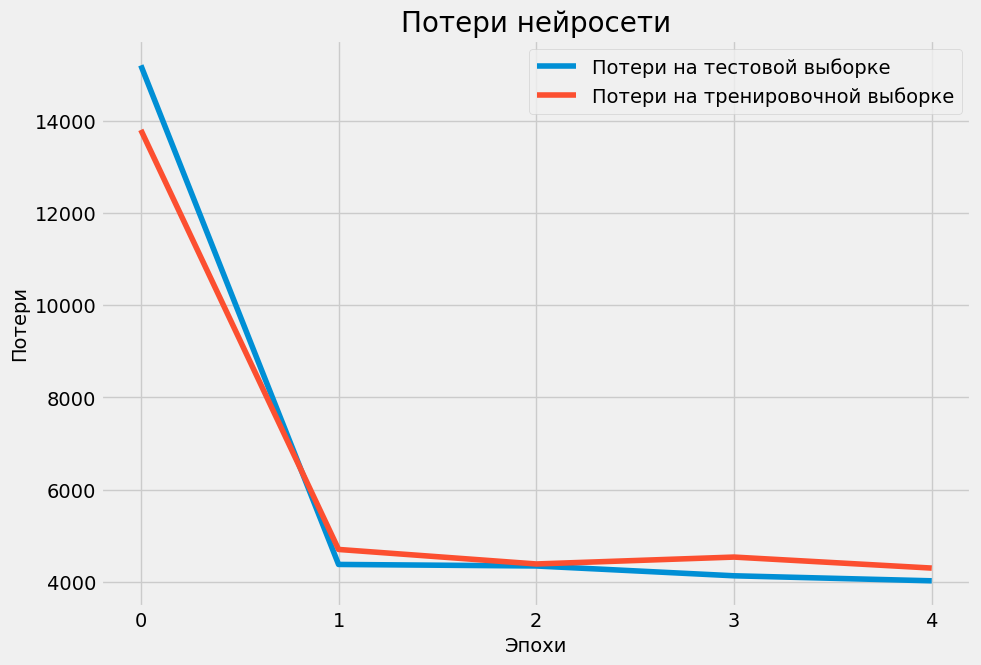

In [49]:
x = np.arange(len(val_loss))

fig, ax = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(7)
ax.set_xticks(x)
val = ax.plot(x, val_loss, label = 'Потери на тестовой выборке')
train = ax.plot(x, train_loss, label = 'Потери на тренировочной выборке')
ax.legend()
ax.set_title('Потери нейросети', fontsize=20)
ax.set_xlabel('Эпохи')
ax.set_ylabel('Потери')
plt.show()

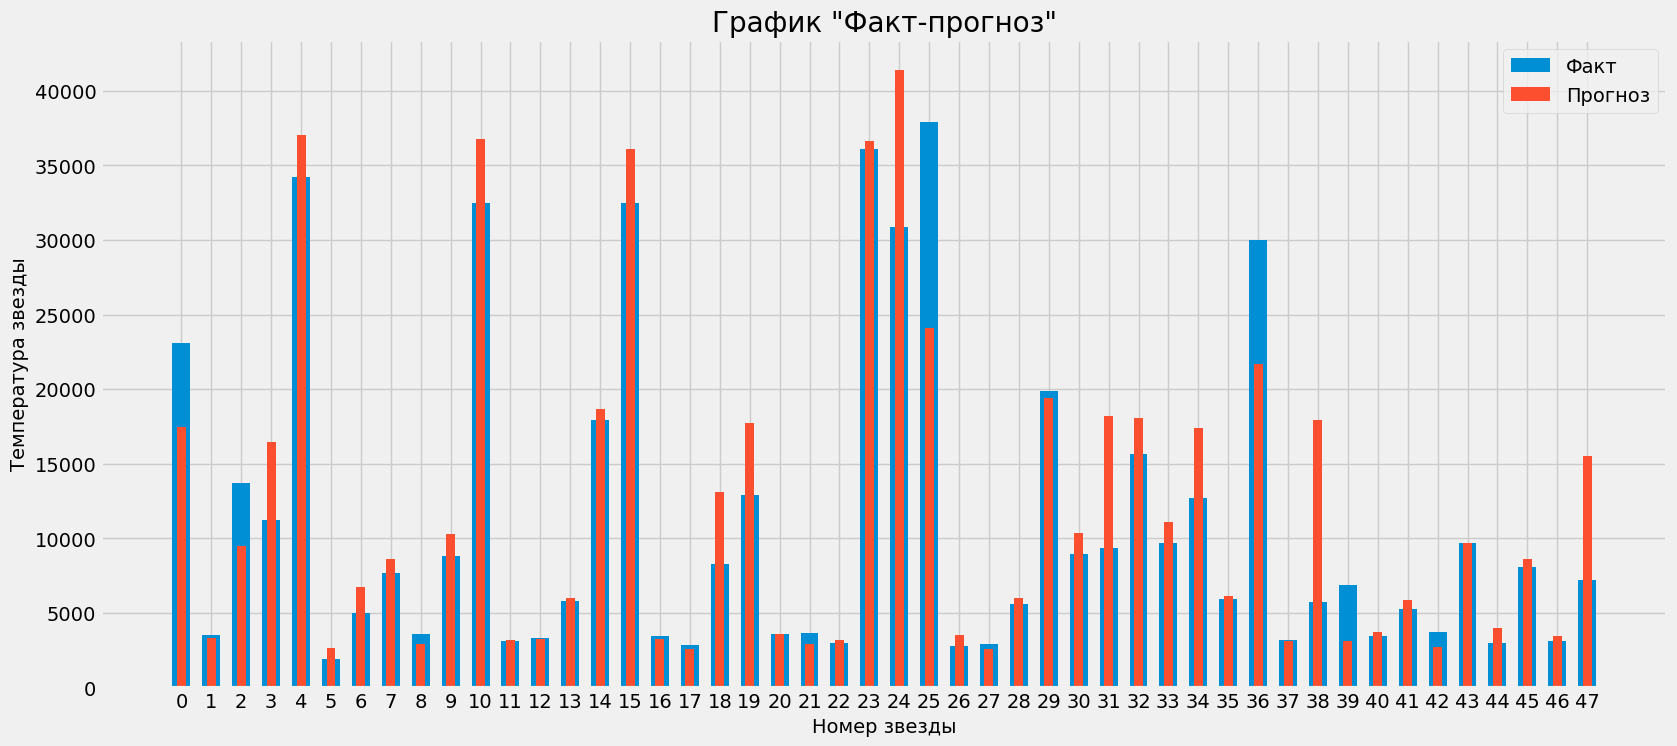

In [50]:
fact_forecast(predicted_temp, target_test)

После улучшения нейросеть показала хорошую метрику на тестовых данных - RMSE 4025, при допустимой минимальной RMSE 4500. Лучшим оптимизатором для этой задачи является Adam с lr 0.01. График потерь показывает, что улучшенная нейросеть обучилась качественно - без недо- и переобучений, благодаря ранней остановке. На графике "Факт-прогноз" видно, что предсказания улучшенной нейросети стали качественнее, чем у базовой нейросети.

## Выводы

После изучения данных провели их предобработку - проверили на дубликаты, привели названия столбцов к стандарту PEP8, объединили неявные дубликаты в столбце `star_color` к единому виду. Проверили анализ каждого признака, аномалий в данных не обнаружено.

Подготовили данные для обучения - разбили на трентровочную и тестовую выборки, масштабировали числовые и закодировали категориальные признаки.

Построили базовую нейронную сеть, подобрали для нее оптимальные параметры. Обучили нейросеть на тренировочной выборке и получили предсказания на тестовой выборке. Получили метрику качества RMSE 4771, что выше заданного значения метрики RMSE 4500. 

Для улучшения модели подобрали оптимайзер, лучшим оказался Adam c гиперпараметром lr 0.01. Подобрали методы регуляризации dropout и BatchNorm. Заново обучили нейросеть и получили на тренировочной выборке предсказания на тестовой выборке. Метрика RMSE значительно улучшилась, показав значение 4025. 

Для наглядного результата работы метрики построили графики "Факт-прогноз" и "Потери нейросети", из которых видно, что модель действительно стала давать более точные предсказания, и что модель хорощо обучается, без недо- и переобучений.

По итогам проведённой работы для улучшения результатов можно дать заказчику следующие рекомендации рекомендации - использовать более качественные данные, увеличить размер датасета, попробовать разные модели обучения, не ограничиваясь нейросетью.